In [1]:
import os

directory = 'C:\\Users\\User\\OneDrive - Asia Pacific University\\FYP\\NewData'
train_dir = os.path.join(directory, 'train')
val_dir = os.path.join(directory, 'val')
test_dir = os.path.join(directory, 'test')

Swin-Transformer (MLP Classifier)

In [2]:
import os
import numpy as np
from PIL import Image
import torch
import timm
from torchvision import transforms
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

#pretrained Swin backbone
device = 'cuda' if torch.cuda.is_available() else 'cpu'
backbone = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    num_classes=0,
    global_pool='avg'
).to(device)
backbone.eval()

def extract_swin_embeddings(data_dir):
    X, y = [], []
    class_names = sorted(d for d in os.listdir(data_dir)
                         if os.path.isdir(os.path.join(data_dir, d)))
    with torch.no_grad():
        for label, cls in enumerate(class_names):
            cls_folder = os.path.join(data_dir, cls)
            for fname in os.listdir(cls_folder):
                fpath = os.path.join(cls_folder, fname)
                try:
                    img = Image.open(fpath).convert('RGB')
                    tensor = transform(img).unsqueeze(0).to(device)
                    emb = backbone(tensor)           
                    X.append(emb.cpu().numpy().ravel())
                    y.append(label)
                except Exception as e:
                    print(f"Skipping {fpath}: {e}")
    return np.vstack(X), np.array(y), class_names

print("Extracting Swin embeddings on TRAIN set…")
X_train, y_train, class_names = extract_swin_embeddings(train_dir)

#SMOTE
print("Applying SMOTE to embeddings…")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

#train MLP classifier
print("Training MLPClassifier on SMOTE data…")
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=True
)
mlp.fit(X_res, y_res)

#evaluation
y_pred = mlp.predict(X_res)
train_acc = accuracy_score(y_res, y_pred)

print(f"\nTraining Accuracy (SMOTE data): {train_acc:.4f}\n")
print("=== Classification Report ===")
print(classification_report(
    y_res,
    y_pred,
    target_names=class_names,
    digits=4
))

print("Extracting Swin embeddings on VAL set…")
X_val, y_val, _ = extract_swin_embeddings(val_dir)
y_val_pred = mlp.predict(X_val)
val_acc    = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_acc:.4f}\n")
print("=== Validation Classification Report ===")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=class_names,
    digits=4
))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting Swin embeddings on TRAIN set…
Applying SMOTE to embeddings…
Training MLPClassifier on SMOTE data…
Iteration 1, loss = 1.06495542
Iteration 2, loss = 0.76859623
Iteration 3, loss = 0.64976038
Iteration 4, loss = 0.57591845
Iteration 5, loss = 0.52920668
Iteration 6, loss = 0.47667736
Iteration 7, loss = 0.42403246
Iteration 8, loss = 0.38897789
Iteration 9, loss = 0.36810329
Iteration 10, loss = 0.34075787
Iteration 11, loss = 0.29638037
Iteration 12, loss = 0.27898071
Iteration 13, loss = 0.25325533
Iteration 14, loss = 0.23279445
Iteration 15, loss = 0.23206968
Iteration 16, loss = 0.20645308
Iteration 17, loss = 0.19839161
Iteration 18, loss = 0.15960355
Iteration 19, loss = 0.14646634
Iteration 20, loss = 0.14533601
Iteration 21, loss = 0.14888244
Iteration 22, loss = 0.12946217
Iteration 23, loss = 0.11130749
Iteration 24, loss = 0.09288267
Iteration 25, loss = 0.10480130
Iteration 26, loss = 0.08401157
Iteration 27, loss = 0.06486733
Iteration 28, loss = 0.09548228
Iter

In [5]:
print("Extracting Swin embeddings on TEST set…")
X_test, y_test, _ = extract_swin_embeddings(test_dir)
y_test_pred = mlp.predict(X_test)
test_acc    = accuracy_score(y_test, y_test_pred)

print(f"\nTest Accuracy: {test_acc:.4f}\n")
print("=== Test Classification Report ===")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=class_names,
    digits=4
))

Extracting Swin embeddings on TEST set…

Test Accuracy: 0.8117

=== Test Classification Report ===
              precision    recall  f1-score   support

           0     0.8569    0.8308    0.8436       526
           1     0.7932    0.8245    0.8085       507
           2     0.7700    0.7222    0.7454       306
           3     0.7655    0.7912    0.7781       297
           4     0.8587    0.8745    0.8665       271

    accuracy                         0.8117      1907
   macro avg     0.8088    0.8087    0.8084      1907
weighted avg     0.8120    0.8117    0.8116      1907



Hyperparameter Tuning

Keras Tuner - Random Search

In [7]:
import keras_tuner as kt
from tensorflow import keras

embed_dim = X_res.shape[1]
num_classes = len(class_names)

def build_swin_mlp(hp):
    inputs = keras.Input(shape=(embed_dim,))
    
    x = inputs
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)
        activation = hp.Choice(f'act_{i}', ['relu', 'tanh'])
        x = keras.layers.Dense(units, activation=activation)(x)
        x = keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1))(x)
    
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_swin_mlp,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_logs',
    project_name='swin_embedding_mlp'
)

tuner.search(
    X_res, y_res,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=2,
    callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5)]
)

best_model_r = tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters:", tuner.get_best_hyperparameters()[0].values)

y_train_pred_prob = best_model_r.predict(X_res, verbose=0)
y_train_pred      = np.argmax(y_train_pred_prob, axis=1)
print(f"\nTraining Accuracy: {accuracy_score(y_res, y_train_pred):.4f}")
print("Training Classification Report:")
print(classification_report(
    y_res,
    y_train_pred,
    target_names=class_names,
    digits=4
))

val_loss, val_acc = best_model_r.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")
print("Validation Classification Report:")
print(classification_report(
    y_val, y_val_pred,
    target_names=class_names,
    digits=4
))

Reloading Tuner from kt_logs\swin_embedding_mlp\tuner0.json


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'num_layers': 2, 'units_0': 512, 'act_0': 'relu', 'dropout_0': 0.30000000000000004, 'learning_rate': 0.0005680298360084579, 'units_1': 320, 'act_1': 'relu', 'dropout_1': 0.1, 'units_2': 448, 'act_2': 'tanh', 'dropout_2': 0.0}

Training Accuracy: 0.9272
Training Classification Report:
              precision    recall  f1-score   support

           0     0.9045    0.9095    0.9070      4208
           1     0.8782    0.8771    0.8777      4208
           2     0.9517    0.9045    0.9275      4208
           3     0.9472    0.9463    0.9467      4208
           4     0.9543    0.9986    0.9760      4208

    accuracy                         0.9272     21040
   macro avg     0.9272    0.9272    0.9270     21040
weighted avg     0.9272    0.9272    0.9270     21040

Validation accuracy: 0.8064
Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8627    0.8479    0.8552       526
           1     0.8131    0.808

Optuna Tuning

In [7]:
import numpy as np
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

def objective(trial):
    n_layers    = trial.suggest_int('n_layers', 1, 3)
    layer_sizes = []
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_categorical(f'layer_size_{i}', [256, 512, 1024]))
    activation      = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha           = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate   = trial.suggest_float('learning_rate_init', 1e-5, 1e-2, log=True)

    mlp = MLPClassifier(
        hidden_layer_sizes=tuple(layer_sizes),
        activation=activation,
        solver='adam',
        alpha=alpha,
        learning_rate_init=learning_rate,
        max_iter=300,
        random_state=42,
        verbose=False
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(mlp, X_res, y_res,
                             cv=cv,
                             scoring='accuracy',
                             n_jobs=1)
    return float(np.mean(scores))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n🔍 Best hyperparameters:", study.best_params)
print(f"🔍 Best CV accuracy:   {study.best_value:.4f}")

best = study.best_params
layer_sizes = [best[f'layer_size_{i}'] for i in range(best['n_layers'])]
final_mlp = MLPClassifier(
    hidden_layer_sizes=tuple(layer_sizes),
    activation=best['activation'],
    solver='adam',
    alpha=best['alpha'],
    learning_rate_init=best['learning_rate_init'],
    max_iter=300,
    random_state=42,
    verbose=False
)
final_mlp.fit(X_res, y_res)

for name, X_split, y_split in [
    ("Train (SMOTE)", X_res,  y_res),
    ("Validation",    X_val,  y_val),
]:
    y_pred = final_mlp.predict(X_split)
    acc    = accuracy_score(y_split, y_pred)
    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(
        y_split, y_pred,
        target_names=class_names,
        digits=4
    ))


[I 2025-07-13 00:16:04,773] A new study created in memory with name: no-name-5e48d263-c8de-407e-b79c-9d835c7775b9
Best trial: 0. Best value: 0.833555:   3%|▎         | 1/30 [08:59<4:20:55, 539.83s/it]

[I 2025-07-13 00:25:04,638] Trial 0 finished with value: 0.833554940325429 and parameters: {'n_layers': 1, 'layer_size_0': 512, 'activation': 'tanh', 'alpha': 0.00013705164633426818, 'learning_rate_init': 0.004139603058124136}. Best is trial 0 with value: 0.833554940325429.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.833555:   7%|▋         | 2/30 [4:44:13<77:16:45, 9935.92s/it]

[I 2025-07-13 05:00:17,786] Trial 1 finished with value: 0.8300856070344897 and parameters: {'n_layers': 3, 'layer_size_0': 1024, 'layer_size_1': 1024, 'layer_size_2': 1024, 'activation': 'tanh', 'alpha': 0.00554950364229737, 'learning_rate_init': 1.1233867342858013e-05}. Best is trial 0 with value: 0.833554940325429.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.841255:  10%|█         | 3/30 [5:12:11<46:14:28, 6165.52s/it]

[I 2025-07-13 05:28:16,538] Trial 2 finished with value: 0.8412548650771763 and parameters: {'n_layers': 1, 'layer_size_0': 256, 'activation': 'tanh', 'alpha': 3.0353031793171383e-05, 'learning_rate_init': 5.945921872415771e-05}. Best is trial 2 with value: 0.8412548650771763.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 3. Best value: 0.87595:  13%|█▎        | 4/30 [7:07:50<46:44:03, 6470.91s/it] 

[I 2025-07-13 07:23:55,635] Trial 3 finished with value: 0.875950380038169 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.0009616637513771542, 'learning_rate_init': 6.398557459310917e-05}. Best is trial 3 with value: 0.875950380038169.


Best trial: 3. Best value: 0.87595:  17%|█▋        | 5/30 [8:32:12<41:24:29, 5962.78s/it]

[I 2025-07-13 08:48:17,423] Trial 4 finished with value: 0.8518066363995781 and parameters: {'n_layers': 3, 'layer_size_0': 512, 'layer_size_1': 256, 'layer_size_2': 256, 'activation': 'tanh', 'alpha': 3.769585234578623e-05, 'learning_rate_init': 5.010284110899312e-05}. Best is trial 3 with value: 0.875950380038169.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 3. Best value: 0.87595:  20%|██        | 6/30 [9:06:54<30:57:15, 4643.14s/it]

[I 2025-07-13 09:22:58,915] Trial 5 finished with value: 0.8280420005087027 and parameters: {'n_layers': 1, 'layer_size_0': 256, 'activation': 'tanh', 'alpha': 5.6784501731622005e-05, 'learning_rate_init': 4.4678959825706695e-05}. Best is trial 3 with value: 0.875950380038169.


Best trial: 3. Best value: 0.87595:  23%|██▎       | 7/30 [29:41:13<174:39:07, 27336.87s/it]

[I 2025-07-14 05:57:18,001] Trial 6 finished with value: 0.8155428904401513 and parameters: {'n_layers': 3, 'layer_size_0': 1024, 'layer_size_1': 1024, 'layer_size_2': 512, 'activation': 'relu', 'alpha': 0.0033558924473120386, 'learning_rate_init': 0.007027115422609969}. Best is trial 3 with value: 0.875950380038169.


Best trial: 3. Best value: 0.87595:  27%|██▋       | 8/30 [29:47:20<114:35:20, 18750.95s/it]

[I 2025-07-14 06:03:25,106] Trial 7 finished with value: 0.8715779348936249 and parameters: {'n_layers': 2, 'layer_size_0': 256, 'layer_size_1': 512, 'activation': 'tanh', 'alpha': 9.066033028468795e-05, 'learning_rate_init': 0.0008323831786414835}. Best is trial 3 with value: 0.875950380038169.


Best trial: 3. Best value: 0.87595:  30%|███       | 9/30 [34:19:08<104:55:32, 17987.25s/it]

[I 2025-07-14 10:35:12,955] Trial 8 finished with value: 0.8373092278704696 and parameters: {'n_layers': 3, 'layer_size_0': 256, 'layer_size_1': 1024, 'layer_size_2': 512, 'activation': 'relu', 'alpha': 0.0034590355707968573, 'learning_rate_init': 0.003513591115766533}. Best is trial 3 with value: 0.875950380038169.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 3. Best value: 0.87595:  33%|███▎      | 10/30 [35:12:36<74:34:53, 13424.67s/it]

[I 2025-07-14 11:28:41,372] Trial 9 finished with value: 0.8545628047511205 and parameters: {'n_layers': 2, 'layer_size_0': 512, 'layer_size_1': 512, 'activation': 'tanh', 'alpha': 5.054212397032487e-05, 'learning_rate_init': 5.2694246572964704e-05}. Best is trial 3 with value: 0.875950380038169.


Best trial: 10. Best value: 0.877804:  37%|███▋      | 11/30 [41:45:41<87:15:48, 16534.11s/it]

[I 2025-07-14 18:01:45,733] Trial 10 finished with value: 0.8778042022871343 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.08965232306545758, 'learning_rate_init': 0.00042939250567508515}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  40%|████      | 12/30 [47:53:26<91:05:01, 18216.72s/it]

[I 2025-07-15 00:09:30,944] Trial 11 finished with value: 0.8753324596181873 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.0998844097901582, 'learning_rate_init': 0.00026112525498738545}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  43%|████▎     | 13/30 [48:15:29<61:51:23, 13099.00s/it]

[I 2025-07-15 00:31:34,016] Trial 12 finished with value: 0.8695345587708019 and parameters: {'n_layers': 2, 'layer_size_0': 1024, 'layer_size_1': 256, 'activation': 'relu', 'alpha': 0.00043473002658585947, 'learning_rate_init': 0.0003343369936534774}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  47%|████▋     | 14/30 [50:53:33<53:21:53, 12007.09s/it]

[I 2025-07-15 03:09:37,891] Trial 13 finished with value: 0.8753326967977091 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.09510941829564915, 'learning_rate_init': 0.0002663675172728217}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  50%|█████     | 15/30 [51:50:18<39:13:33, 9414.23s/it] 

[I 2025-07-15 04:06:23,254] Trial 14 finished with value: 0.8712452330134974 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.015820217847068704, 'learning_rate_init': 0.0007417082411060561}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  53%|█████▎    | 16/30 [52:18:39<27:34:54, 7092.48s/it]

[I 2025-07-15 04:34:44,054] Trial 15 finished with value: 0.8659222943234415 and parameters: {'n_layers': 2, 'layer_size_0': 1024, 'layer_size_1': 512, 'activation': 'relu', 'alpha': 0.0003461275850832861, 'learning_rate_init': 0.00012222611484875599}. Best is trial 10 with value: 0.8778042022871343.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 10. Best value: 0.877804:  57%|█████▋    | 17/30 [53:08:28<21:09:20, 5858.50s/it]

[I 2025-07-15 05:24:32,819] Trial 16 finished with value: 0.8283745397514437 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.0010991295571689554, 'learning_rate_init': 1.2483668208879947e-05}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  60%|██████    | 18/30 [54:53:16<19:57:32, 5987.70s/it]

[I 2025-07-15 07:09:21,287] Trial 17 finished with value: 0.8546103084210671 and parameters: {'n_layers': 2, 'layer_size_0': 1024, 'layer_size_1': 256, 'activation': 'relu', 'alpha': 0.020348346248632423, 'learning_rate_init': 0.0013148917303182398}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  63%|██████▎   | 19/30 [55:35:59<15:09:11, 4959.26s/it]

[I 2025-07-15 07:52:04,765] Trial 18 finished with value: 0.8761881897798856 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 1.0998166152504121e-05, 'learning_rate_init': 0.00011842780110418434}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  67%|██████▋   | 20/30 [55:49:58<10:20:20, 3722.03s/it]

[I 2025-07-15 08:06:03,215] Trial 19 finished with value: 0.868868687428061 and parameters: {'n_layers': 2, 'layer_size_0': 512, 'layer_size_1': 256, 'activation': 'relu', 'alpha': 1.89107174932119e-05, 'learning_rate_init': 0.00013589107777549117}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  70%|███████   | 21/30 [56:04:02<7:08:44, 2858.31s/it] 

[I 2025-07-15 08:20:07,785] Trial 20 finished with value: 0.8682510109641588 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 1.1346043268984137e-05, 'learning_rate_init': 0.0017618418851717106}. Best is trial 10 with value: 0.8778042022871343.


Best trial: 10. Best value: 0.877804:  73%|███████▎  | 22/30 [56:43:31<6:01:31, 2711.42s/it]

[I 2025-07-15 08:59:36,646] Trial 21 finished with value: 0.8769961587624423 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.0013266791210821418, 'learning_rate_init': 0.00012147967825889864}. Best is trial 10 with value: 0.8778042022871343.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 22. Best value: 0.880465:  77%|███████▋  | 23/30 [62:14:30<15:16:39, 7857.00s/it]

[I 2025-07-15 14:30:35,273] Trial 22 finished with value: 0.8804654107346882 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.026827130610023304, 'learning_rate_init': 0.0001395512425060923}. Best is trial 22 with value: 0.8804654107346882.


Best trial: 22. Best value: 0.880465:  80%|████████  | 24/30 [69:05:30<21:29:52, 12898.73s/it]

[I 2025-07-15 21:21:34,652] Trial 23 finished with value: 0.8776139572043843 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.036878791306307494, 'learning_rate_init': 0.000496424099010021}. Best is trial 22 with value: 0.8804654107346882.


Best trial: 22. Best value: 0.880465:  83%|████████▎ | 25/30 [72:49:59<18:09:09, 13070.00s/it]

[I 2025-07-16 01:06:04,255] Trial 24 finished with value: 0.8769960977734224 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.036044779055693595, 'learning_rate_init': 0.0004693951306743157}. Best is trial 22 with value: 0.8804654107346882.


Best trial: 22. Best value: 0.880465:  87%|████████▋ | 26/30 [74:30:14<12:10:12, 10953.23s/it]

[I 2025-07-16 02:46:19,164] Trial 25 finished with value: 0.8698192826219392 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.039116069752743614, 'learning_rate_init': 0.0006107190664298362}. Best is trial 22 with value: 0.8804654107346882.


Best trial: 22. Best value: 0.880465:  90%|█████████ | 27/30 [76:54:17<8:33:00, 10260.22s/it] 

[I 2025-07-16 05:10:22,515] Trial 26 finished with value: 0.867822786725748 and parameters: {'n_layers': 2, 'layer_size_0': 1024, 'layer_size_1': 1024, 'activation': 'relu', 'alpha': 0.00972827251201274, 'learning_rate_init': 0.0015175272026089663}. Best is trial 22 with value: 0.8804654107346882.


Best trial: 22. Best value: 0.880465:  93%|█████████▎| 28/30 [79:10:52<5:21:20, 9640.49s/it] 

[I 2025-07-16 07:26:57,085] Trial 27 finished with value: 0.879087384159658 and parameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.0457393017965104, 'learning_rate_init': 0.00020475769544507148}. Best is trial 22 with value: 0.8804654107346882.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 22. Best value: 0.880465:  97%|█████████▋| 29/30 [82:07:51<2:45:34, 9934.19s/it]

[I 2025-07-16 10:23:56,479] Trial 28 finished with value: 0.8514733856182714 and parameters: {'n_layers': 1, 'layer_size_0': 512, 'activation': 'relu', 'alpha': 0.052647619449023124, 'learning_rate_init': 3.14143723244731e-05}. Best is trial 22 with value: 0.8804654107346882.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 22. Best value: 0.880465: 100%|██████████| 30/30 [82:44:07<00:00, 9928.25s/it]  


[I 2025-07-16 11:00:12,254] Trial 29 finished with value: 0.8714352138104946 and parameters: {'n_layers': 1, 'layer_size_0': 256, 'activation': 'relu', 'alpha': 0.012198845011100789, 'learning_rate_init': 0.00017698699641915255}. Best is trial 22 with value: 0.8804654107346882.

🔍 Best hyperparameters: {'n_layers': 1, 'layer_size_0': 1024, 'activation': 'relu', 'alpha': 0.026827130610023304, 'learning_rate_init': 0.0001395512425060923}
🔍 Best CV accuracy:   0.8805

📊 Train (SMOTE) Accuracy: 0.9995
              precision    recall  f1-score   support

           0     0.9983    0.9990    0.9987      4208
           1     0.9990    0.9983    0.9987      4208
           2     1.0000    1.0000    1.0000      4208
           3     1.0000    1.0000    1.0000      4208
           4     1.0000    1.0000    1.0000      4208

    accuracy                         0.9995     21040
   macro avg     0.9995    0.9995    0.9995     21040
weighted avg     0.9995    0.9995    0.9995     21040


📊 Valid

RandomizedSearchCV

In [3]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform, randint
from sklearn.metrics import accuracy_score, classification_report

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp',   MLPClassifier(max_iter=300, random_state=42))
])

param_dist = {
    'mlp__hidden_layer_sizes': [(512,), (256,), (512,256), (256,256), (512,256,128)],
    'mlp__activation':         ['relu','tanh'],
    'mlp__solver':             ['adam','sgd'],
    'mlp__alpha':              loguniform(1e-5, 1e-1),
    'mlp__learning_rate':      ['constant','adaptive'],
    'mlp__learning_rate_init': loguniform(1e-4, 1e-2),
    'mlp__early_stopping':     [True],
    'mlp__n_iter_no_change':   [10, 20],
    'mlp__batch_size':         [32, 64]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rs.fit(X_train, y_train)

print("🔍 Best hyperparameters:", rs.best_params_)
print(f"🔍 Best CV accuracy:  {rs.best_score_:.4f}")

#evaluation
best_pipe = rs.best_estimator_
for name, X_split, y_split in [
    ("Train", X_train, y_train),
    ("Validation", X_val, y_val),
]:
    y_pred = best_pipe.predict(X_split)
    acc    = accuracy_score(y_split, y_pred)
    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(
        y_split, y_pred,
        target_names=class_names,
        digits=4
    ))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
🔍 Best hyperparameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.000224109716191095, 'mlp__batch_size': 32, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.00027385989615856803, 'mlp__n_iter_no_change': 20, 'mlp__solver': 'adam'}
🔍 Best CV accuracy:  0.8088

📊 Train Accuracy: 0.9862
              precision    recall  f1-score   support

           0     0.9869    0.9855    0.9862      4208
           1     0.9853    0.9768    0.9810      4051
           2     0.9782    0.9882    0.9831      2448
           3     0.9874    0.9920    0.9897      2374
           4     0.9945    0.9968    0.9956      2170

    accuracy                         0.9862     15251
   macro avg     0.9865    0.9878    0.9871     15251
weighted avg     0.9862    0.9862    0.9862     15251


📊 Validation Accuracy: 0.8253
              precision    recall  f1-score   su

Best Model

In [4]:
X_test, y_test, _ = extract_swin_embeddings(test_dir)

y_pred = best_pipe.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
print(f"\n📊 Test Accuracy: {acc:.4f}")
print(classification_report(
    y_test, y_pred,
    target_names=class_names,
    digits=4
))


📊 Test Accuracy: 0.8034
              precision    recall  f1-score   support

           0     0.8259    0.8479    0.8368       526
           1     0.8004    0.7515    0.7752       507
           2     0.7682    0.7582    0.7632       306
           3     0.7508    0.7710    0.7608       297
           4     0.8592    0.9004    0.8793       271

    accuracy                         0.8034      1907
   macro avg     0.8009    0.8058    0.8030      1907
weighted avg     0.8029    0.8034    0.8028      1907



Learning Curve

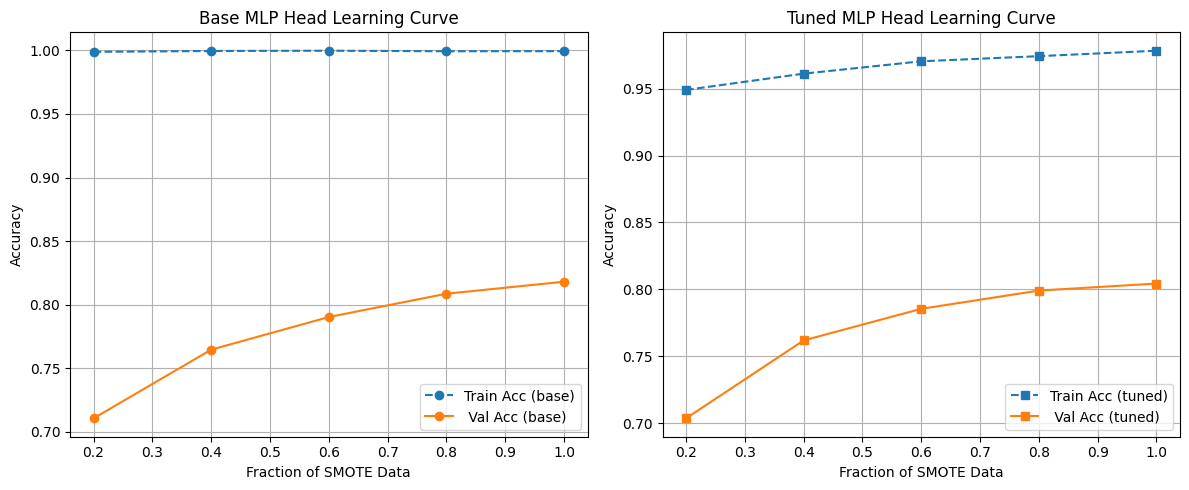

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier

fractions = np.linspace(0.2, 1.0, 5) 

train_acc_base  = []
val_acc_base    = []
train_acc_tuned = []
val_acc_tuned   = []

sss = StratifiedShuffleSplit(n_splits=1, train_size=None, random_state=42)

def make_base():
    return MLPClassifier(
        hidden_layer_sizes=(512,256),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42,
        verbose=False
    )


tuned_params = best_pipe.named_steps['mlp'].get_params()
tuned_params.update({
    'early_stopping': True,
    'validation_fraction': 0.2,
    'n_iter_no_change': 10,
    'verbose': False
})

for frac in fractions:
    if frac < 1.0:
        # get indices for a full random stratified split, then trim
        full_idx, _ = next(sss.split(X_res, y_res))
        n_sub       = int(len(full_idx) * frac)
        sel         = full_idx[:n_sub]
        X_sub, y_sub = X_res[sel], y_res[sel]
    else:
        X_sub, y_sub = X_res, y_res

    # base head
    base_clf = make_base()
    base_clf.fit(X_sub, y_sub)
    train_acc_base.append(base_clf.score(X_sub, y_sub))
    val_acc_base.append(base_clf.score(X_val, y_val))

    # tuned head
    tuned_clf = MLPClassifier(**tuned_params)
    tuned_clf.fit(X_sub, y_sub)
    train_acc_tuned.append(tuned_clf.score(X_sub, y_sub))
    val_acc_tuned.append(tuned_clf.score(X_val, y_val))

#plot learning curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fractions, train_acc_base,  'o--', label='Train Acc (base)')
plt.plot(fractions, val_acc_base,    'o-',  label=' Val Acc (base)')
plt.title("Base MLP Head Learning Curve")
plt.xlabel("Fraction of SMOTE Data")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fractions, train_acc_tuned, 's--', label='Train Acc (tuned)')
plt.plot(fractions, val_acc_tuned,   's-',  label=' Val Acc (tuned)')
plt.title("Tuned MLP Head Learning Curve")
plt.xlabel("Fraction of SMOTE Data")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


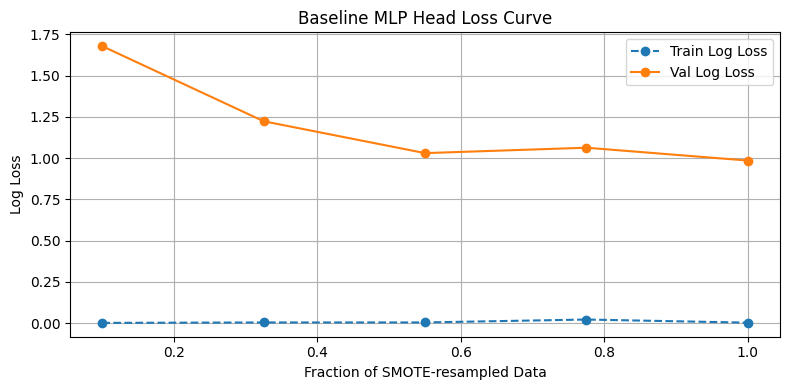

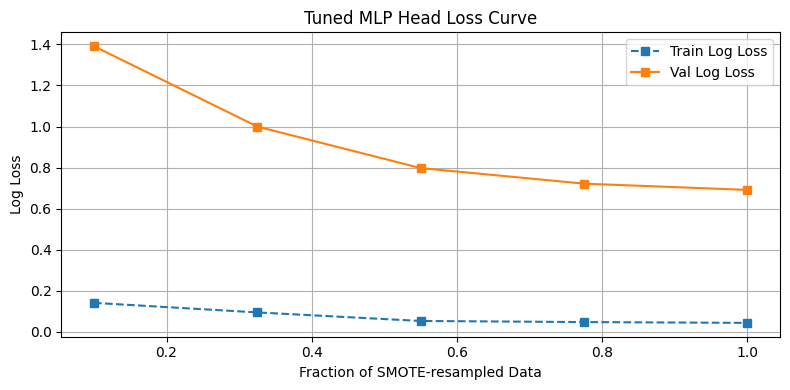

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier

fractions = np.linspace(0.1, 1.0, 5)

train_loss_base = []
val_loss_base   = []
train_loss_tuned = []
val_loss_tuned   = []

num_classes = len(class_names)

for frac in fractions:
    if frac < 1.0:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=42)
        train_idx, _ = next(sss.split(X_res, y_res))
        X_frac, y_frac = X_res[train_idx], y_res[train_idx]
    else:
        X_frac, y_frac = X_res, y_res
    # Base MLP
    base_clf = MLPClassifier(
        hidden_layer_sizes=(512, 256),
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42
    )
    base_clf.fit(X_frac, y_frac)
    y_prob_train_base = base_clf.predict_proba(X_frac)
    y_prob_val_base   = base_clf.predict_proba(X_val)
    train_loss_base.append(log_loss(y_frac, y_prob_train_base, labels=list(range(num_classes))))
    val_loss_base.append(log_loss(y_val, y_prob_val_base, labels=list(range(num_classes))))

    # Tuned MLP
    tuned_params = best_pipe.named_steps['mlp'].get_params()
    tuned_clf = MLPClassifier(**tuned_params)
    tuned_clf.fit(X_frac, y_frac)
    
    y_prob_train_tuned = tuned_clf.predict_proba(X_frac)
    y_prob_val_tuned   = tuned_clf.predict_proba(X_val)
    train_loss_tuned.append(log_loss(y_frac, y_prob_train_tuned, labels=list(range(num_classes))))
    val_loss_tuned.append(log_loss(y_val, y_prob_val_tuned, labels=list(range(num_classes))))

# Plot Baseline Loss Curve
plt.figure(figsize=(8,4))
plt.plot(fractions, train_loss_base, 'o--', label='Train Log Loss')
plt.plot(fractions, val_loss_base,   'o-',  label='Val Log Loss')
plt.title("Baseline MLP Head Loss Curve")
plt.xlabel("Fraction of SMOTE-resampled Data")
plt.ylabel("Log Loss")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Tuned Loss Curve
plt.figure(figsize=(8,4))
plt.plot(fractions, train_loss_tuned, 's--', label='Train Log Loss')
plt.plot(fractions, val_loss_tuned,   's-',  label='Val Log Loss')
plt.title("Tuned MLP Head Loss Curve")
plt.xlabel("Fraction of SMOTE-resampled Data")
plt.ylabel("Log Loss")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


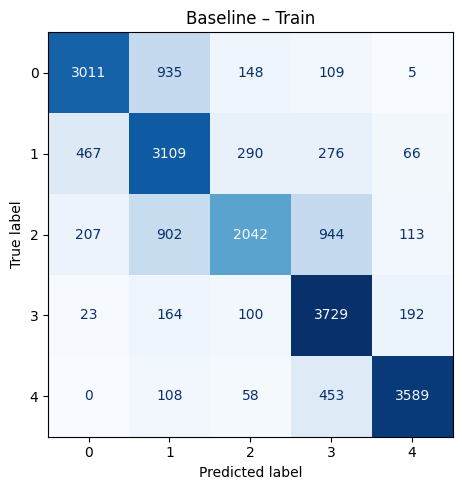

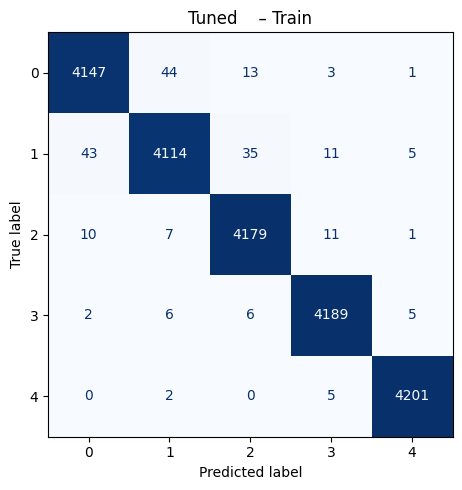

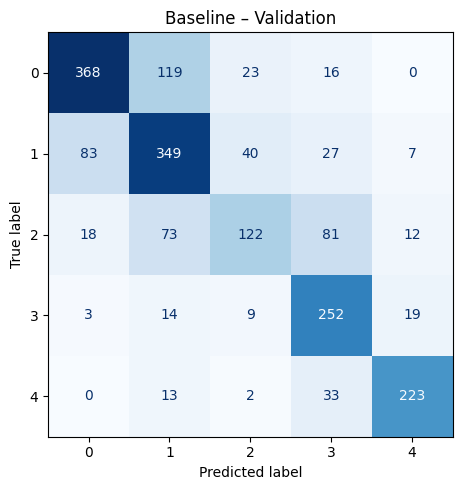

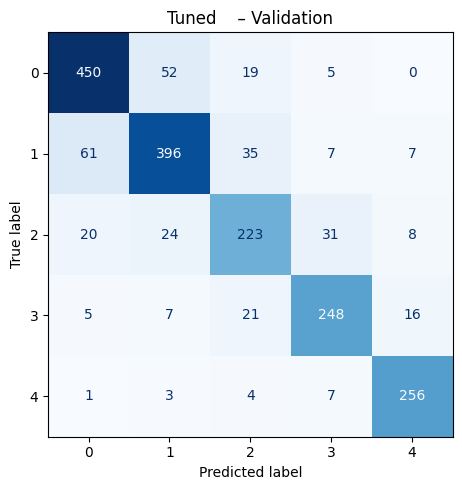

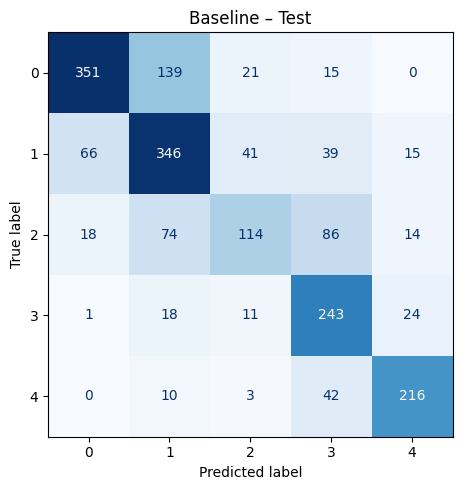

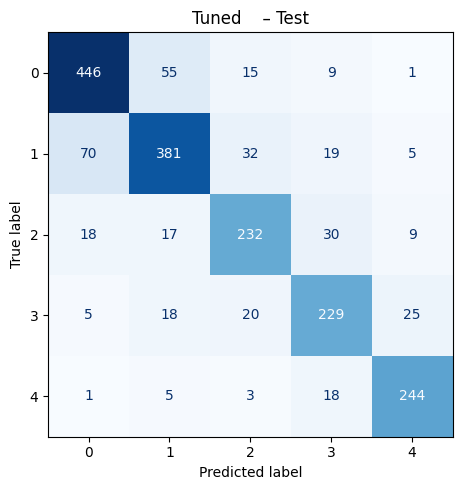

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

splits = [
    ('Train',      X_res,    y_res),
    ('Validation', X_val,    y_val),
    ('Test',       X_test,   y_test),
]

for split_name, X_split, y_split in splits:
    # Base
    y_pred_base = best_pipe.predict(X_split)
    cm_base     = confusion_matrix(y_split, y_pred_base, labels=list(range(num_classes)))
    disp_base   = ConfusionMatrixDisplay(cm_base, display_labels=class_names)
    fig, ax     = plt.subplots(figsize=(5,5))
    disp_base.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(f"Baseline – {split_name}")
    plt.tight_layout()
    plt.show()
    
    # Tuned
    cm_tuned     = confusion_matrix(y_split, y_pred, labels=list(range(num_classes)))
    disp_tuned   = ConfusionMatrixDisplay(cm_tuned, display_labels=class_names)
    fig, ax      = plt.subplots(figsize=(5,5))
    disp_tuned.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(f"Tuned    – {split_name}")
    plt.tight_layout()
    plt.show()


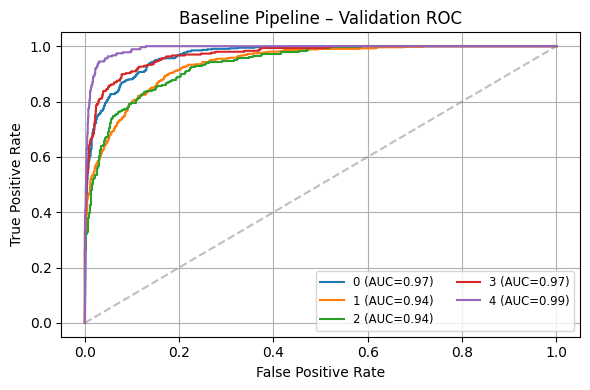

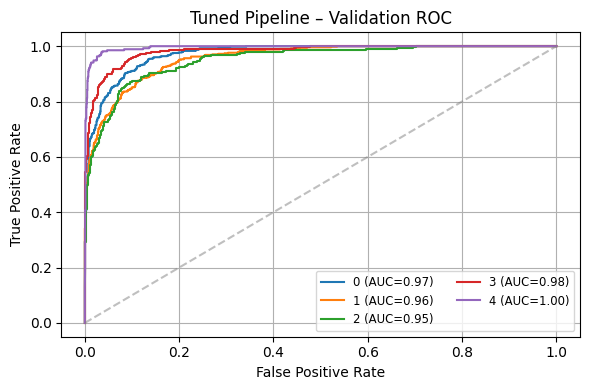

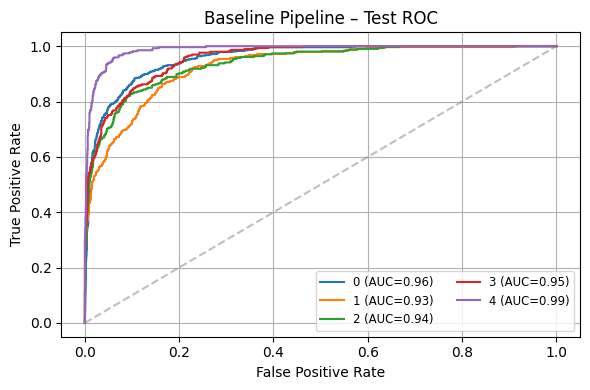

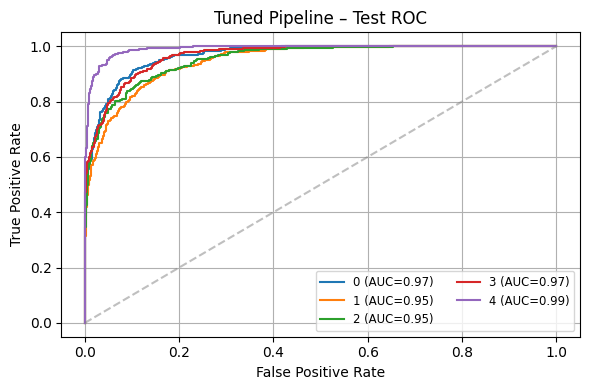

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

pipeline.fit(X_res, y_res)
classes = list(range(len(class_names)))
y_res_bin = label_binarize(y_res, classes=classes)
y_val_bin = label_binarize(y_val, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

splits = [
    ("Validation", X_val,  y_val_bin),
    ("Test",       X_test, y_test_bin),
]

models = [
    ("Baseline", pipeline),
    ("Tuned",    best_pipe),
]

# ROC curves
for split_name, X_split, y_bin in splits:
    for model_name, model in models:
        y_prob = model.predict_proba(X_split)
        fpr, tpr, roc_auc = {}, {}, {}
        for i in classes:
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(6, 4))
        for i, cls in enumerate(class_names):
            plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.2f})")
        plt.plot([0,1], [0,1], "--", color="gray", alpha=0.5)
        plt.title(f"{model_name} Pipeline – {split_name} ROC")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="best", fontsize="small", ncol=2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
